In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **OVERVIEW**
This code preprocesses a dataset of radiology and non-radiology images along with their captions for an image captioning task. The `clean_text` function preprocesses the captions by converting text to lowercase, removing URLs, numbers, special characters, and stopwords, while applying stemming and lemmatization. After loading and cleaning the captions, it processes images from specified directories, applies transformations, and maps the images to their respective captions, splitting the data into training, validation, and test sets.

Next, the code constructs a deep learning model using a CNN (InceptionV3) for feature extraction and an RNN (LSTM) for caption sequence processing. After defining and compiling the model, it trains it on the prepared datasets and evaluates performance on the training and test sets, calculating accuracy and loss. Predictions are made on the validation set, with metrics like precision, recall, and F1 score computed. Finally, the training and validation accuracy are visualized in a plot to illustrate the model's learning progress throughout the epochs.

# **TEXT PREPROCESING**

This code preprocesses captions from a CSV file for a radiology dataset using NLTK. It defines a `clean_text` function that converts text to lowercase, removes URLs and special characters, eliminates numbers and stopwords, and applies stemming and lemmatization. After applying this function to the captions, it stores the results in a new column and exports the cleaned data to `preprocessed_captions1.csv`.

In [2]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [3]:
import nltk

In [4]:
!pip install nltk

In [5]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron

True

In [6]:
import os
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet 

In [7]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
#captions path
train_captions = '/kaggle/input/roco-dataset/all_data/train/radiologytraindata.csv'

In [9]:
#Function for preprocessing the captions
def clean_text(input_text):
    # Convert text to lowercase
    lower_text = input_text.lower()
    # Remove URLs
    no_urls = re.sub(r'http\S+|www\S+|ftp\S+', '', lower_text)
    # Replace new lines with space
    no_newlines = no_urls.replace('\n', ' ')
    # Remove words containing numbers
    no_numbers = re.sub(r'\w*\d\w*', '', no_newlines)
    # Remove extra spaces and trim text
    trimmed_text = re.sub(r'\s+', ' ', no_numbers).strip()
    # Remove special characters
    clean_text = re.sub(r'[^\w\s]', '', trimmed_text)
    # Split text into words
    word_list = clean_text.split()
    # Remove stopwords
    stop_words_set = set(stopwords.words('english'))
    filtered_words = [word for word in word_list if word not in stop_words_set]
    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    # Apply stemming
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    # Apply lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    # Join words back into a single string
    final_text = ' '.join(lemmatized_words)

    return final_text

In [10]:
captions_data=pd.read_csv(train_captions)
print("CAPTION BEFORE PREPROCESSING\n",captions_data.head())

CAPTION BEFORE PREPROCESSING
            id                                    name  \
0  ROCO_00002          PMC4083729_AMHSR-4-14-g002.jpg   
1  ROCO_00003       PMC2837471_IJD2009-150251.001.jpg   
2  ROCO_00004  PMC2505281_11999_2007_30_Fig6_HTML.jpg   
3  ROCO_00005       PMC3745845_IJD2013-683423.005.jpg   
4  ROCO_00007   PMC4917066_amjcaserep-17-301-g001.jpg   

                                             caption  
0   Computed tomography scan in axial view showin...  
1   Bacterial contamination occurred after comple...  
2   The patient had residual paralysis of the han...  
3    Panoramic radiograph after immediate loading.\n  
4   Plain abdomen x-ray: Multiple air levels at t...  


In [11]:
captions_data['preprocessed_captions']=captions_data['caption'].apply(clean_text)
print("CAPTION AFTER PREPROCESSING\n", captions_data[['caption', 'preprocessed_captions']].head())

CAPTION AFTER PREPROCESSING
                                              caption  \
0   Computed tomography scan in axial view showin...   
1   Bacterial contamination occurred after comple...   
2   The patient had residual paralysis of the han...   
3    Panoramic radiograph after immediate loading.\n   
4   Plain abdomen x-ray: Multiple air levels at t...   

                               preprocessed_captions  
0  comput tomographi scan axial view show obliter...  
1  bacteri contamin occur complet root canal trea...  
2  patient residu paralysi hand poliomyel necessa...  
3                     panoram radiograph immedi load  
4  plain abdomen xray multipl air level midabdome...  


In [12]:
#exporting the preprocessed text to a CSV file
captions_data.to_csv('preprocessed_captions1.csv', index=False)

# **Image Preprocessing**

This code processes images from specified directories for a deep learning task, using PyTorch and torchvision for image transformations. It checks for CUDA availability to utilize GPU acceleration if possible. The `process_images` function processes images from specified directories and returns a list of image tensors with their labels after reaching a specified limit.

In [13]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image, UnidentifiedImageError
import torchvision.transforms as transforms
import torch

2024-07-12 03:44:20.530065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 03:44:20.530202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 03:44:20.662450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Step 1: Load the image using PI
image_dirs =['/kaggle/input/roco-dataset/all_data/train/non-radiology/images','/kaggle/input/roco-dataset/all_data/train/radiology/images']

In [16]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),          # Convert the image to a tensor
])

In [17]:
#The `process_images` function takes in directories containing images, applies transformations (resizing to 224x224 pixels and converting to tensors), and loads the images while handling exceptions for unidentified files. Each processed image tensor is stored alongside its corresponding label in a list, which is returned after processing a specified limit of images from each directory.
def process_images(image_dirs, device, transform, limit=1200):

    #Process images from the given directories, apply transformations, and move them to the specified device.

    processed_images = []
    for dir_path in image_dirs:
        label = os.path.basename(dir_path)  # Use the directory name as the label
        image_files = os.listdir(dir_path)  # List all files in the directory

        processed_count = 0
        for img_file in image_files:
            if processed_count >= limit:
                break

            img_path = os.path.join(dir_path, img_file)  # Full path to the image file
            try:
                img = Image.open(img_path).convert('RGB')  # Open the image and convert to RGB
                img_tensor = transform(img)  # Apply transformations
                img_tensor = img_tensor.permute(1, 2, 0)  # Transpose dimensions to (224, 224, 3)
                img_tensor = img_tensor.to(device)  # Move the tensor to the specified device
                processed_images.append((img_tensor, label))  # Append the tensor and label to the list
                processed_count += 1
            except UnidentifiedImageError:
                print(f"UnidentifiedImageError: cannot identify image file '{img_path}', skipping.")

    return processed_images


**Mapping Images to the Captions**

This code maps processed images to their corresponding captions, organizing the data into training, validation, and test sets. The `map_images_to_captions` function splits the images, reads preprocessed captions from a CSV, and creates DataFrames while removing the label column. The resulting DataFrames are saved as pickle files.
After defining the captions path, the code processes images and calls the mapping function to generate the DataFrames. It then prints the first few rows of each DataFrame to confirm that the images and captions are correctly aligned for further use.

In [18]:
def map_images_to_captions(processed_images, captions_data):

    #Map images to their respective captions and split into train, validation, and test DataFrames.
    # Split the data into training, validation, and test sets
    train_images = processed_images[:850]
    val_images = processed_images[850:950]
    test_images = processed_images[950:1200]

    def create_image_caption_df(images, captions):
        #Create a DataFrame to store image tensors and corresponding captions.
        image_tensors = [img_tensor.cpu().numpy() for img_tensor, _ in images]  # Convert tensors to numpy arrays
        labels = [label for _, label in images]
        captions_list = captions.values  # Use values to get the array of captions
        df = pd.DataFrame({
            "image_tensor": image_tensors,
            "label": labels,
            "caption": captions_list
        })
        return df

    # Ensure you have loaded the preprocessed captions DataFrame
    captions_data = pd.read_csv(captions_data)

    # Select the respective preprocessed captions
    train_captions = captions_data['preprocessed_captions'].iloc[:850]
    val_captions = captions_data['preprocessed_captions'].iloc[850:950]
    test_captions = captions_data['preprocessed_captions'].iloc[950:1200]

    # Create DataFrames for train, validation, and test sets
    train_df = create_image_caption_df(train_images, train_captions)
    val_df = create_image_caption_df(val_images, val_captions)
    test_df = create_image_caption_df(test_images, test_captions)

    # Remove the 'label' column from the dataframes
    train_df = train_df.drop(columns=['label'])
    val_df = val_df.drop(columns=['label'])
    test_df = test_df.drop(columns=['label'])
    
    # Save the DataFrames to CSV or pickle files
    train_df.to_pickle("train_image_caption_mapping.pkl")
    val_df.to_pickle("val_image_caption_mapping.pkl")
    test_df.to_pickle("test_image_caption_mapping.pkl")

    return train_df, val_df, test_df

In [19]:
captions_path = 'preprocessed_captions1.csv'

# Process the images from the specified directories
processed_images = process_images(image_dirs, device, transform)

# Map the images to their respective captions and split into train, validation, and test DataFrames
train_df, val_df, test_df = map_images_to_captions(processed_images, captions_path)

# Print the first few rows of each DataFrame
print("Train DataFrame:\n", train_df.head(),"\n")
print("Validation DataFrame:\n", val_df.head(),"\n")
print("Test DataFrame:\n", test_df.head())

Train DataFrame:
                                         image_tensor  \
0  [[[0.011764706, 0.011764706, 0.011764706], [0....   
1  [[[0.07450981, 0.08627451, 0.09411765], [0.082...   
2  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...   
3  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...   
4  [[[0.11764706, 0.11764706, 0.11764706], [0.117...   

                                             caption  
0  comput tomographi scan axial view show obliter...  
1  bacteri contamin occur complet root canal trea...  
2  patient residu paralysi hand poliomyel necessa...  
3                     panoram radiograph immedi load  
4  plain abdomen xray multipl air level midabdome...   

Validation DataFrame:
                                         image_tensor  \
0  [[[0.20392157, 0.2509804, 0.18431373], [0.2470...   
1  [[[0.14901961, 0.14901961, 0.14901961], [0.109...   
2  [[[0.043137256, 0.023529412, 0.007843138], [0....   
3  [[[0.019607844, 0.019607844, 0.019607844], [0....   
4  [[[0.47

# **MODEL 1 : CNN + RNN**


This code preprocesses image captions for a deep learning model that combines CNN and LSTM architectures to generate captions for images. It begins by tokenizing the captions, creating sequences, and padding them to a maximum length. The `create_sequences` function prepares the input data by generating image tensors and their corresponding caption sequences, formatted for model training. The InceptionV3 model serves as a feature extractor, while an LSTM processes the sequences, with both components combined in the decoder to produce the final output.After defining the model, it compiles it with categorical crossentropy loss and trains it for ten epochs using the training data. The model's performance is evaluated on both the training and test sets, and various metrics, including accuracy, precision, recall, and F1 score, are calculated for the validation set. Finally, the training and validation accuracies are plotted to visualize the model's performance over epochs.

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [21]:
#Tokenizes the captions, generates sequences, and determines the maximum sequence length and vocabulary size.
def preprocess_text(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    sequences = tokenizer.texts_to_sequences(captions)
    max_length = max(len(seq) for seq in sequences)
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    return tokenizer, max_length, vocab_size

train_captions = train_df['caption']
tokenizer, max_length, vocab_size = preprocess_text(train_captions)


# Creates input sequences and output vectors for the model from captions and corresponding image tensors.
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = [], [], []
    for i in range(len(descriptions)):
        desc = descriptions[i]
        photo = photos[i]
        seq = tokenizer.texts_to_sequences([desc])[0]
        for j in range(1, len(seq)):
            in_seq, out_seq = seq[:j], seq[j]
            in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
            out_seq_vec = np.zeros(vocab_size)
            out_seq_vec[out_seq] = 1
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq_vec)
    return np.array(X1), np.array(X2), np.array(y)

# Create sequences for training
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_df['caption'], train_df['image_tensor'])
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_df['caption'], test_df['image_tensor'])

In [22]:
#Defines a hybrid model combining a CNN (InceptionV3) for image features and an LSTM for sequence processing to predict caption words.
def define_model(vocab_size, max_length):
    # Feature extractor (CNN) part
    inputs1 = Input(shape=(224, 224, 3))
    model = InceptionV3(include_top=False, pooling='avg')
    for layer in model.layers:
        layer.trainable = False
    fe1 = model(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Sequence processor (RNN) part
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, use_cudnn=False)(se2)
    
    # Decoder (combining both inputs)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model = define_model(vocab_size, max_length)
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 78)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 78, 256)   │    740,864 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 2048)      │ 21,802,784 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 78, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 78)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ inception_v3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout[0][0],    │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2894)      │    743,758 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,403,054 (93.09 MB)

 Trainable params: 2,600,270 (9.92 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [23]:
epochs = 10
batch_size = 64

In [26]:
# Example of adding accuracy metric (for illustration, not commonly used in captioning)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
history = model.fit([X1train, X2train], ytrain, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
  1/136 ━━━━━━━━━━━━━━━━━━━━ 35:29 16s/step - accuracy: 0.3594 - loss: 2.6058

W0000 00:00:1720756401.498580     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720756401.499926     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720756401.630795     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.3198 - loss: 2.6394

W0000 00:00:1720756427.062882     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720756427.085592     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720756435.837698     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 57s 308ms/step - accuracy: 0.3194 - loss: 2.6408 - val_accuracy: 0.0615 - val_loss: 10.2345
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.3997 - loss: 2.2023 - val_accuracy: 0.0550 - val_loss: 11.4999
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.4684 - loss: 1.9418 - val_accuracy: 0.0578 - val_loss: 12.6798
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.5201 - loss: 1.6518 - val_accuracy: 0.0550 - val_loss: 13.0133
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.5797 - loss: 1.4502 - val_accuracy: 0.0555 - val_loss: 13.9265
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.6383 - loss: 1.2322 - val_accuracy: 0.0596 - val_loss: 14.6225
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.6936 - loss: 1.0653 - val_accuracy: 0.0610 - val_loss: 15.3832
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.7341 - loss: 0.894

In [28]:
# Evaluate on training set
train_loss, train_acc = model.evaluate([X1train, X2train], ytrain, verbose=0)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_acc}")

W0000 00:00:1720756749.099587     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training Loss: 3.8205153942108154, Training Accuracy: 0.7362921833992004


In [29]:
# Evaluate on test set
test_loss, test_acc = model.evaluate([X1test, X2test], ytest, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Test Loss: 16.672693252563477, Test Accuracy: 0.05178837478160858


W0000 00:00:1720756817.382019     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [31]:
# Predictions on validation set
X1val, X2val, yval = create_sequences(tokenizer, max_length, val_df['caption'], val_df['image_tensor'])
val_predictions = model.predict([X1val, X2val], verbose=0)

In [32]:
# Convert predictions and ground truth to class labels
yval_classes = np.argmax(yval, axis=1)
val_pred_classes = np.argmax(val_predictions, axis=1)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 0.051353874883286646
Validation Precision: 0.05167592372134406
Validation Recall: 0.051353874883286646
Validation F1 Score: 0.04665098399371103


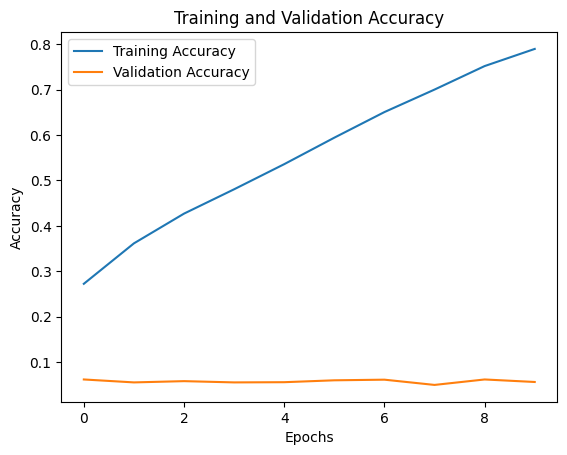

In [36]:
# Calculate performance metrics
val_accuracy = accuracy_score(yval_classes, val_pred_classes)
val_precision = precision_score(yval_classes, val_pred_classes, average='weighted')
val_recall = recall_score(yval_classes, val_pred_classes, average='weighted')
val_f1 = f1_score(yval_classes, val_pred_classes, average='weighted')

print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1 Score: {val_f1}")

# Plot training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()